In [86]:
import pandas as pd
train = pd.read_csv('data/train.csv')  # Đường dẫn file của em
print(train.head())  # Xem 5 dòng đầu
print(train.info())  # Xem kiểu dữ liệu và missing values
print(train.describe())  # Thống kê số học

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [87]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


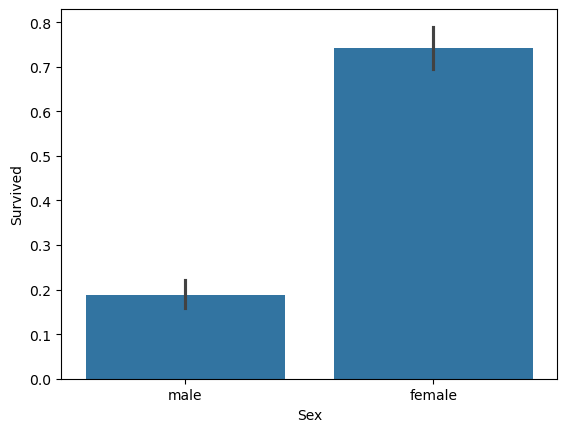

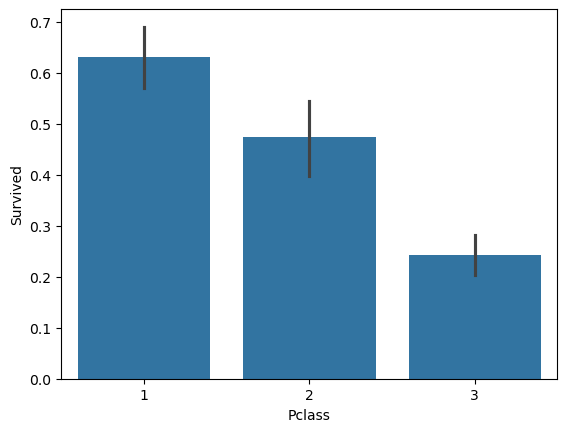

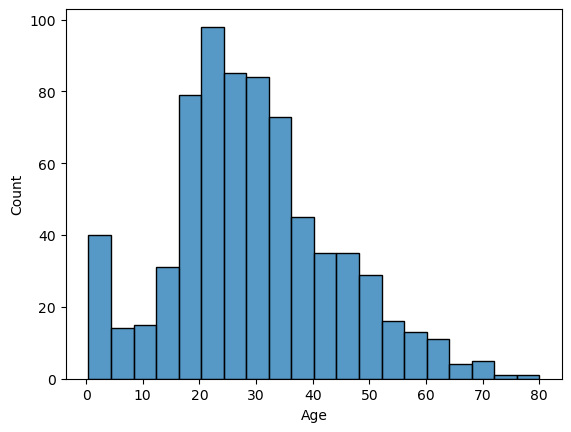

<Axes: >

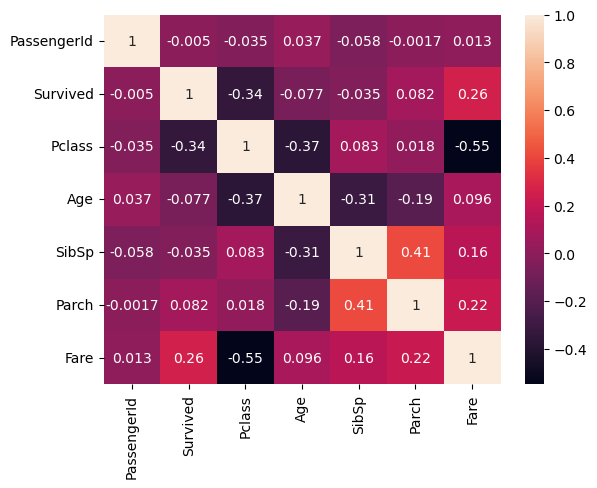

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tỷ lệ sống sót theo Sex
sns.barplot(x='Sex', y='Survived', data=train)
plt.show()  # Nữ: ~74% sống, Nam: ~19%

# Theo Pclass
sns.barplot(x='Pclass', y='Survived', data=train)  # Hạng 1: 63%, Hạng 3: 25%
plt.show()

# Phân bố Age
sns.histplot(train['Age'].dropna(), bins=20)  # Đỉnh ở 20-30 tuổi
plt.show()

# Correlation heatmap (xem mối liên hệ)
sns.heatmap(train.corr(numeric_only=True), annot=True)  # Fare và Pclass liên quan âm

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Hàm preprocess (copy từ code trước của em)
def preprocess(df):
    try:
        df = df.copy()
        df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
        df['Age'].fillna(27, inplace=True)
        df['FamilySize'] = df['SibSp'] + df['Parch'] 
        df['IsAlone'] = (df['FamilySize'] == 0).astype(int)
        df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        df['Title'] = df['Title'].replace('Mlle', 'Miss')
        df['Title'] = df['Title'].replace('Ms', 'Miss')
        df['Title'] = df['Title'].replace('Mme', 'Mrs')
        df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True)
        df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Title'], drop_first=True)
        df['AgeBin'] = pd.cut(df['Age'], bins=[0, 13, 18, 35, 64, 81], labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
        df = pd.get_dummies(df, columns=['AgeBin'], drop_first=True)
        df['Fare'] = df['Fare'].fillna(df['Fare'].median())
        df['LogFare'] = np.log1p(df['Fare'])
        return df
    except Exception as e:
        print(f"Lỗi trong preprocess: {e}")
        return None

# Load và preprocess train data (để train lại mô hình)
train = pd.read_csv('data/train.csv')  # Thay đường dẫn đúng
train_clean = preprocess(train)

# Train mô hình Random Forest
X = train_clean.drop('Survived', axis=1)
y = train_clean['Survived']
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)  # Train trên toàn bộ train data

# Load và preprocess test data
test = pd.read_csv('data/test.csv')  # Thay đường dẫn đúng
test_passenger_ids = test['PassengerId']  # Lưu PassengerId để submit
test_clean = preprocess(test)

# Dự đoán trên test data
predictions = rf.predict(test_clean)

# Tạo file submission
submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predictions
})
submission.to_csv('submission3.csv', index=False)
print("File submission3.csv đã được tạo!")

File submission3.csv đã được tạo!


C:\Users\ThaiTu\AppData\Local\Temp\ipykernel_5772\1120134666.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(10, inplace=True)
C:\Users\ThaiTu\AppData\Local\Temp\ipykernel_5772\1120134666.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Chuẩn bị X, y
X = train_clean.drop('Survived', axis=1)
y = train_clean['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mô hình 1: Logistic (đơn giản, interpret dễ)
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"Accuracy Logistic: {accuracy_score(y_test, y_pred_lr):.2f}")  # ~0.78-0.80

# Mô hình 2: Random Forest (mạnh hơn, handle non-linear tốt)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"Accuracy RF: {accuracy_score(y_test, y_pred_rf):.2f}")  # ~0.82-0.85

# Feature importance (xem cột nào quan trọng)
importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
print(importances.head())  # Thường: Sex_female, Pclass_3, Age, Title_Mr...

# Score: 0.75598

c:\Users\ThaiTu\AppData\Local\Programs\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Logistic: 0.80
Accuracy RF: 0.82
     feature  importance
1        Age    0.174421
18   LogFare    0.145205
4       Fare    0.141826
7   Sex_male    0.127571
11  Title_Mr    0.122678
